# Small network (one E- and one I-populations)

We use this notebook to generate the data and plots focusing on the generation of gamma oscillations through E-I coupling for the revision of the eLife manuscript.

There are several cases:
* [Disconnected](#disconnected_case) network of E-I, receiving a ramping input on E/I/E-I
* [Amelie's connections](#connected_case_Amelie) (i.e. p_all = \[0, 0.3, 0.3, 0.7\] for E->E, E->I, I->E, I->I), ramping input
* Low vs high noise; we show how noise affects the synchronization of the network

We will save the rasters in separate folders for plotting stuff later (in case we need it) under `data/fig_gamma_small_net/`.

## Libraries and initializations

Here we import all the necessary libraries for the simulations. We have separated the equations and the common (global) variables and kept only the parameters that we will need for the simulations.

In [1]:
import os

from brian2 import *
from scipy.signal import welch
from matplotlib import ticker

from ModelFiles.equations import *
from ModelFiles.functions import *
from ModelFiles.global_parameters import *

In [2]:
""" Simulation parameters and inputs """
duration = 5*second
dt_sim = defaultclock.dt
ftheta = 6*Hz

# Connection probabilities
p_all = [0]*400
# p_all = [0., 0.3, 0.3, 0.7]    # E->E, E->I, I->E, I->I
# p_all = [0., 0.5, 0.5, 0.5]    # E->E, E->I, I->E, I->I

# Folders
spikesdir = os.path.join('data', 'fig_gamma_small_net', 'spikes')
statemondatadir = os.path.join('data', 'fig_gamma_small_net', 'data')
figdir = os.path.join('data', 'fig_gamma_small_net', 'figures')

# Populations
N_E = 1000
N_I = 100

# Time vector
tv = arange(0, duration, dt_sim)

# Inputs
tonic_input = 0.1
stim_input = 8.
ramp_min = 0.
ramp_max = 1.
ramp_peak_t = 5*second

# Ramping input - non-repeating
dt_ramp = 1*ms
fs_ramp = 1/dt_ramp
xvals = np.arange(0, (ramp_peak_t/second), dt_ramp /second)
ramp = ramp_min + (ramp_max-ramp_min)/(ramp_peak_t/second) * xvals

# TimedArrays
# inputs_drive = TimedArray(np.array([0, 0.5, 0.5, 0.5, 0.5])*nA, dt=1*second)
inputs_drive = TimedArray(ramp*nA, dt=dt_ramp)
inputs_stim = TimedArray(np.array([0]*400 + [stim_input]*2 + [0])*nA, dt=1*ms)
inputs_tonic = TimedArray(([0.] + [tonic_input]*10 + [0.])*nA, dt=1.*second)

# Tonic inputs control
rin_E = 0
rin_I = 0

# Disable the ramp input
r_drive_E = 0
r_drive_I = 0

# Disable tonic input
rin_E = 0
rin_I = 0

# Disable stim input
r_E = 0
r_I = 0

# Set the RNG seed (reproducible results)
seed(42)

# Initial conditions (fixed)
Vm_E_init = (-60 + 10*randn(N_E))*mV
Vm_I_init = (-60 + 10*randn(N_I))*mV

## Network initialization

First of all, we will make a network. We create the E-I populations, the synapses, and the monitors, add them to the network, and then decide if we want to connect them and with what probabilities.

In [3]:
# Neuron Groups
# -------------------------------------------------------------------
# Excitatory
G_E = NeuronGroup(N=N_E,
    model=py_CAN_inp_eqs,
    threshold='v>V_th',
    # reset=reset_eqs,
    reset=reset_eqs_noCl,
    refractory=refractory_time,
    method=integ_method,
    name='pyCAN')
G_E.size = cell_size_py
G_E.glu = 1
G_E.v = Vm_E_init
G_E.r_drive = 0
G_E.rin = 0
G_E.r = 0

# Inhibitory
G_I = NeuronGroup(N=N_I,
    model=inh_inp_eqs,
    threshold='v>V_th',
    refractory=refractory_time,
    method=integ_method,
    name='inh')
G_I.size = cell_size_inh
G_I.v = Vm_I_init
G_I.r_drive = 0
G_I.rin = 0
G_I.r = 0

# Synapse creation
syn_EE = Synapses(G_E, G_E, on_pre="he_post+="+str(gains_all[3][0])+"*"+str(g_max_e/psiemens)+"*psiemens*glu_pre", name=G_E.name+"_to_"+G_E.name) # create synapse
syn_EI = Synapses(G_E, G_I, on_pre="he_post+="+str(gains_all[3][0])+"*"+str(g_max_e/psiemens)+"*psiemens*glu_pre", name=G_E.name+"_to_"+G_I.name) # create the excitatory synapse on the inhibitory population
syn_IE = Synapses(G_I, G_E, on_pre="hi_post+="+str(gains_all[3][1])+"*"+str(g_max_i/psiemens)+"*psiemens", name=G_I.name+"_to_"+G_E.name) # create the inhibitory synapse on the excitatory population
syn_II = Synapses(G_I, G_I, on_pre="hi_post+="+str(gains_all[3][1])+"*"+str(g_max_i/psiemens)+"*psiemens", name=G_I.name+"_to_"+G_I.name)


# One unit to get the summed Vm for E and one for I units
# -------------------------------------------------------------------
G_Vm_sumE = NeuronGroup(1, eq_record_neurons, name='Vm_sum_E')
G_Vm_sumI = NeuronGroup(1, eq_record_neurons, name='Vm_sum_I')

Syn_Vm_E = Synapses(G_E, G_Vm_sumE, model=eq_record_synapses)
Syn_Vm_E.connect()

Syn_Vm_I = Synapses(G_I, G_Vm_sumI, model=eq_record_synapses)
Syn_Vm_I.connect()


# One unit records both I_SynE and I_SynI
# -------------------------------------------------------------------
G_ISyn_sumE = NeuronGroup(1, eq_record_LFP_neurons, name='ISyn_sum_E')
G_ISyn_sumI = NeuronGroup(1, eq_record_LFP_neurons, name='ISyn_sum_I')

Syn_Isyn_E = Synapses(G_E, G_ISyn_sumE, model=eq_record_LFP_synapses)
Syn_Isyn_E.connect()

Syn_Isyn_I = Synapses(G_I, G_ISyn_sumI, model=eq_record_LFP_synapses)
Syn_Isyn_I.connect()


# Monitors
# -------------------------------------------------------------------
statemon_GE = StateMonitor(G_E, ['v', 'I_SynE', 'I_SynI'], record=True, name='Statemon_E')
statemon_GI = StateMonitor(G_I, ['v', 'I_SynE', 'I_SynI'], record=True, name='Statemon_I')

spikemon_GE = SpikeMonitor(G_E, name='Spikes_E')
spikemon_GI = SpikeMonitor(G_I, name='Spikes_I')

ratemon_GE = PopulationRateMonitor(G_E)
ratemon_GI = PopulationRateMonitor(G_I)

statemon_Vm_avg_GE = StateMonitor(G_Vm_sumE, ['sum_v'], record=True, name='Statemon_Vm_E')
statemon_Vm_avg_GI = StateMonitor(G_Vm_sumI, ['sum_v'], record=True, name='Statemon_Vm_I')

statemon_ISyn_GE = StateMonitor(G_ISyn_sumE, ['sum_I_SynE', 'sum_I_SynI'], record=True, name='Statemon_syncurr_E')
statemon_ISyn_GI = StateMonitor(G_ISyn_sumI, ['sum_I_SynE', 'sum_I_SynI'], record=True, name='Statemon_syncurr_I')

In [4]:
# Network
net = Network()

# Add groups
net.add(G_E, G_I)
net.add(G_Vm_sumE, G_Vm_sumI) 
net.add(G_ISyn_sumE, G_ISyn_sumI)

# Add synapses
net.add(syn_EE, syn_EI, syn_IE, syn_II)
net.add(Syn_Vm_E, Syn_Vm_I)
net.add(Syn_Isyn_E, Syn_Isyn_I)

# Add monitors
net.add(statemon_GE, statemon_GI)
net.add(spikemon_GE, spikemon_GI)
net.add(ratemon_GE, ratemon_GI)
net.add(statemon_Vm_avg_GE, statemon_Vm_avg_GI)
net.add(statemon_ISyn_GE, statemon_ISyn_GI)

# Store a snapshot of the network
net.store('initialized')

<a id='disconnected_case'></a>

## Disconnected case

The network is completely disconnected. We will generate data and then make the figures later.We will generate data and then make the figures later.

In [5]:
# Restore the net
net.restore('initialized')

In [6]:
# Disable all connections
p_all = [0]*4

# Synapse connections
syn_EE.connect(condition='i!=j', p=p_all[0]) # connect E2E
syn_EI.connect(p=p_all[1]) # connect E2I
syn_IE.connect(p=p_all[2]) # connect I2E
syn_II.connect(condition='i!=j', p=p_all[3]) # connect I2I

In [7]:
# Use this noise
sigma_noise_inh = 0.*uvolt
sigma_noise_exc = 0.*uvolt

In [8]:
# Enable ramping input to populations
r_drive_E = 1
r_drive_I = 1

G_E.r_drive = r_drive_E 
G_I.r_drive = r_drive_I 

# Filenames
fname = f"input_ramp_E_{bool(r_drive_E)}_I_{bool(r_drive_I)}_noise_E_{sigma_noise_exc/uvolt:0.0f}uV_I_{sigma_noise_inh/uvolt:0.0f}uV"

In [9]:
# Run the simulation
net.run(duration, report='text', report_period=5*second)

Starting simulation at t=0. s for a duration of 5. s
1.2369 s (24%) simulated in 5s, estimated 15s remaining.
2.4693 s (49%) simulated in 10s, estimated 10s remaining.
3.6728 s (73%) simulated in 15s, estimated 5s remaining.
4.9437 s (98%) simulated in 20s, estimated < 1s remaining.
5. s (100%) simulated in 20s


In [10]:
# Save the spike data
# E
np.savetxt(os.path.join(spikesdir, f"DC_{G_E.name}_{fname}_i.txt"), np.array(spikemon_GE.i).astype(np.int16), fmt='%d')
np.savetxt(os.path.join(spikesdir, f"DC_{G_E.name}_{fname}_t.txt"), np.array(spikemon_GE.t/ms).astype(np.float32), fmt='%.1f')

# I
np.savetxt(os.path.join(spikesdir, f"DC_{G_I.name}_{fname}_i.txt"), np.array(spikemon_GI.i).astype(np.int16), fmt='%d')
np.savetxt(os.path.join(spikesdir, f"DC_{G_I.name}_{fname}_t.txt"), np.array(spikemon_GI.t/ms).astype(np.float32), fmt='%.1f')

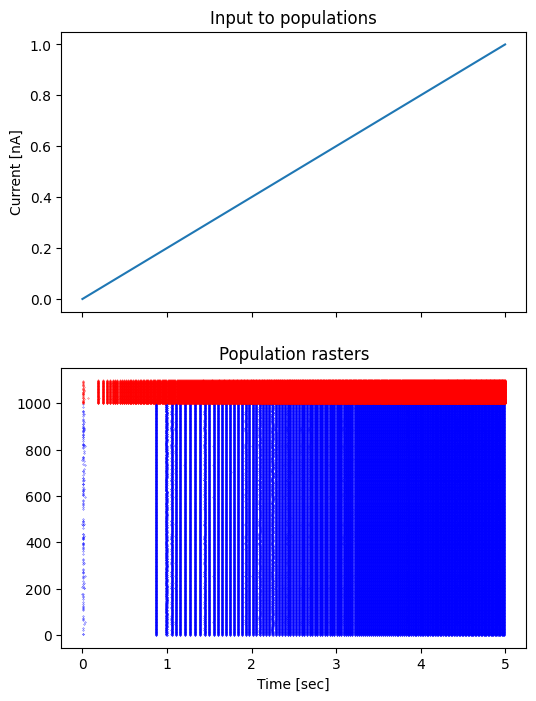

In [11]:
# Make a plot
tv = np.arange(0, duration/second, dt_ramp/second)

fig,axs = plt.subplots(2,1, figsize=(6,8), sharex=True)

# Signal 
axs[0].plot(tv, inputs_drive(tv*second)/nA)
axs[0].set_title('Input to populations')
axs[0].set_ylabel('Current [nA]')

# Rasters
axs[1].plot(spikemon_GE.t/second, spikemon_GE.i, 'b.', markersize=0.5)
axs[1].plot(spikemon_GI.t/second, spikemon_GI.i+N_E, 'r.', markersize=0.5)
axs[1].set_title('Population rasters')
axs[1].set_xlabel('Time [sec]')

plt.show()

<a id='connected_case_Amelie'></a>

## Connected case

The network is coupled, following the connection probabilities of CA1. We will generate data and then make the figures later.

In [12]:
# Restore the net
net.restore('initialized')

In [13]:
# Disable all connections
p_all = [0., 0.3, 0.3, 0.7]

# Synapse connections
syn_EE.connect(condition='i!=j', p=p_all[0]) # connect E2E
syn_EI.connect(p=p_all[1]) # connect E2I
syn_IE.connect(p=p_all[2]) # connect I2E
syn_II.connect(condition='i!=j', p=p_all[3]) # connect I2I

In [14]:
# Use this noise
sigma_noise_inh = 0.*uvolt
sigma_noise_exc = 0.*uvolt

In [15]:
# Enable ramping input to populations
r_drive_E = 1
r_drive_I = 0

G_E.r_drive = r_drive_E 
G_I.r_drive = r_drive_I 

# Filenames
fname = f"input_ramp_E_{bool(r_drive_E)}_I_{bool(r_drive_I)}_noise_E_{sigma_noise_exc/uvolt:0.0f}uV_I_{sigma_noise_inh/uvolt:0.0f}uV"

In [16]:
# Run the simulation
net.run(duration, report='text', report_period=5*second)

Starting simulation at t=0. s for a duration of 5. s
1.2971 s (25%) simulated in 5s, estimated 14s remaining.
2.5964 s (51%) simulated in 10s, estimated 9s remaining.
3.897 s (77%) simulated in 15s, estimated 4s remaining.
5. s (100%) simulated in 19s


In [17]:
# Save the spike data
# E
np.savetxt(os.path.join(spikesdir, f"CON_Amelie_{G_E.name}_{fname}_i.txt"), np.array(spikemon_GE.i).astype(np.int16), fmt='%d')
np.savetxt(os.path.join(spikesdir, f"CON_Amelie_{G_E.name}_{fname}_t.txt"), np.array(spikemon_GE.t/ms).astype(np.float32), fmt='%.1f')

# I
np.savetxt(os.path.join(spikesdir, f"CON_Amelie_{G_I.name}_{fname}_i.txt"), np.array(spikemon_GI.i).astype(np.int16), fmt='%d')
np.savetxt(os.path.join(spikesdir, f"CON_Amelie_{G_I.name}_{fname}_t.txt"), np.array(spikemon_GI.t/ms).astype(np.float32), fmt='%.1f')

1. kHz 5000


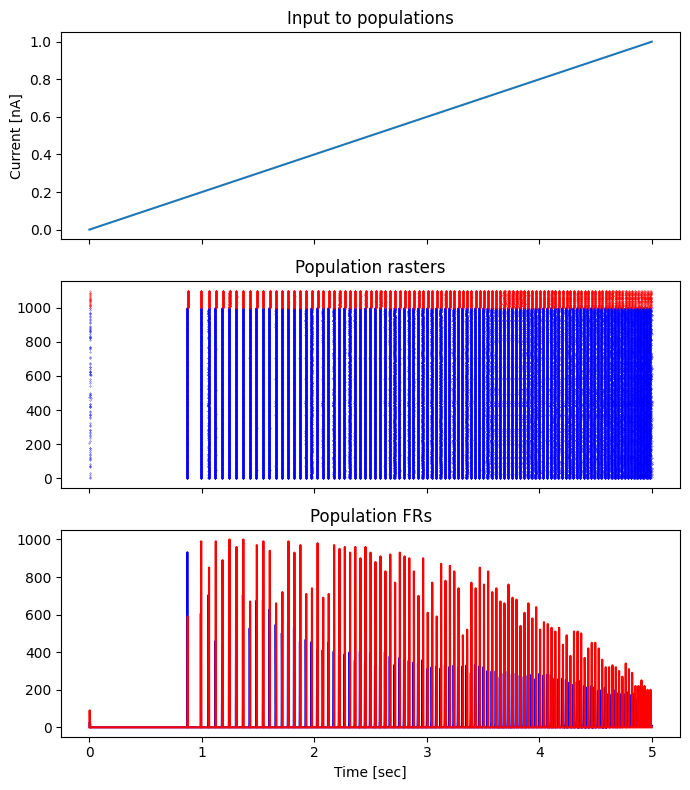

In [18]:
# Parameters for FRs
window_size = 1*ms
bin_num = int(duration/window_size)
fs_FR = 1/window_size

print(fs_FR, bin_num)

# Calculate the FRs
FR_E, tv_E = np.histogram(spikemon_GE.t/second, bins=bin_num, range=[0,duration/second])
FR_I, tv_I = np.histogram(spikemon_GI.t/second, bins=bin_num, range=[0,duration/second])

# Plot the FRs
fig,axs = plt.subplots(3,1, figsize=(7,8), sharex=True)

# Signal 
axs[0].plot(tv, inputs_drive(tv*second)/nA)
axs[0].set_title('Input to populations')
axs[0].set_ylabel('Current [nA]')

# Rasters
axs[1].plot(spikemon_GE.t/second, spikemon_GE.i, 'b.', markersize=0.5)
axs[1].plot(spikemon_GI.t/second, spikemon_GI.i+N_E, 'r.', markersize=0.5)
axs[1].set_title('Population rasters')

# FRs
axs[2].plot(tv_E[0:-1]*second+window_size/2, FR_E/window_size/N_E, 'b')
axs[2].plot(tv_I[0:-1]*second+window_size/2, FR_I/window_size/N_I, 'r')
axs[2].set_title('Population FRs')
axs[2].set_xlabel('Time [sec]')
# axs[2].set_xlim([3.25, 3.75])

plt.tight_layout()
plt.show()

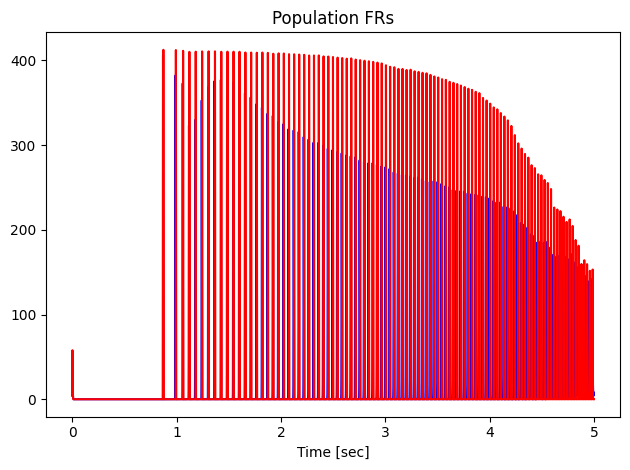

In [19]:
# FRs
plt.plot(ratemon_GE.t/second, ratemon_GE.smooth_rate(width=1*ms), 'b')
plt.plot(ratemon_GE.t/second, ratemon_GI.smooth_rate(width=1*ms), 'r')
plt.title('Population FRs')
plt.xlabel('Time [sec]')
# plt.xlim([3.25, 3.75])

plt.tight_layout()
plt.show()

In [20]:
tE, FR_E_cust, fs_FR_cust = my_FR(spikemon_GE.t/second, duration/second, window_size/second, 0.9)

In [21]:
print(len(FR_E_cust), len(FR_E))
print(tE[1:10], tv_E[1:10])
print(fs_FR, fs_FR_cust)

49991 5000
[0.0006 0.0007 0.0008 0.0009 0.001  0.0011 0.0012 0.0013 0.0014] [0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009]
1. kHz 10000


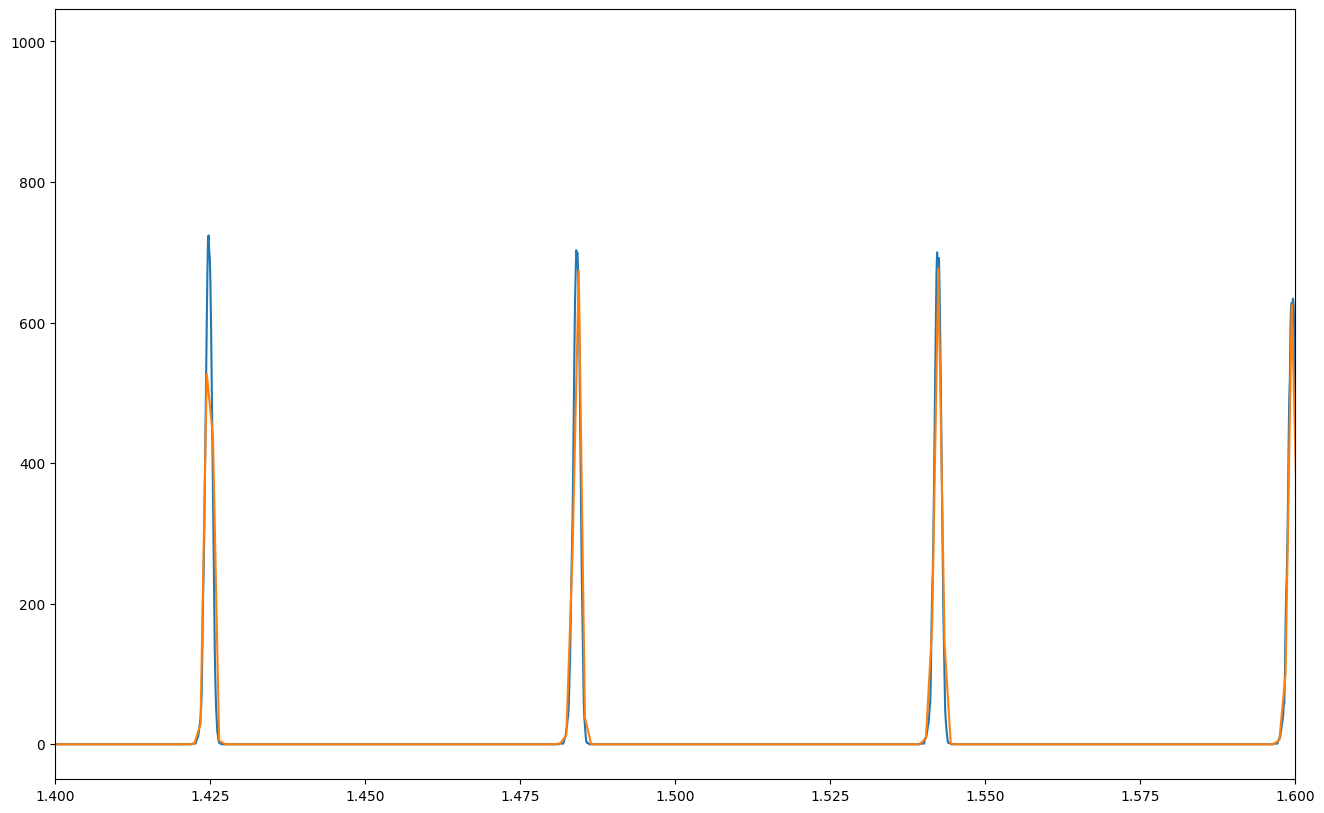

In [22]:
plt.figure(figsize=(16,10))
plt.plot(tE, FR_E_cust/N_E)
plt.plot(tv_E[0:-1]*second+window_size/2, FR_E)
plt.xlim((1.4,1.6))
plt.show()

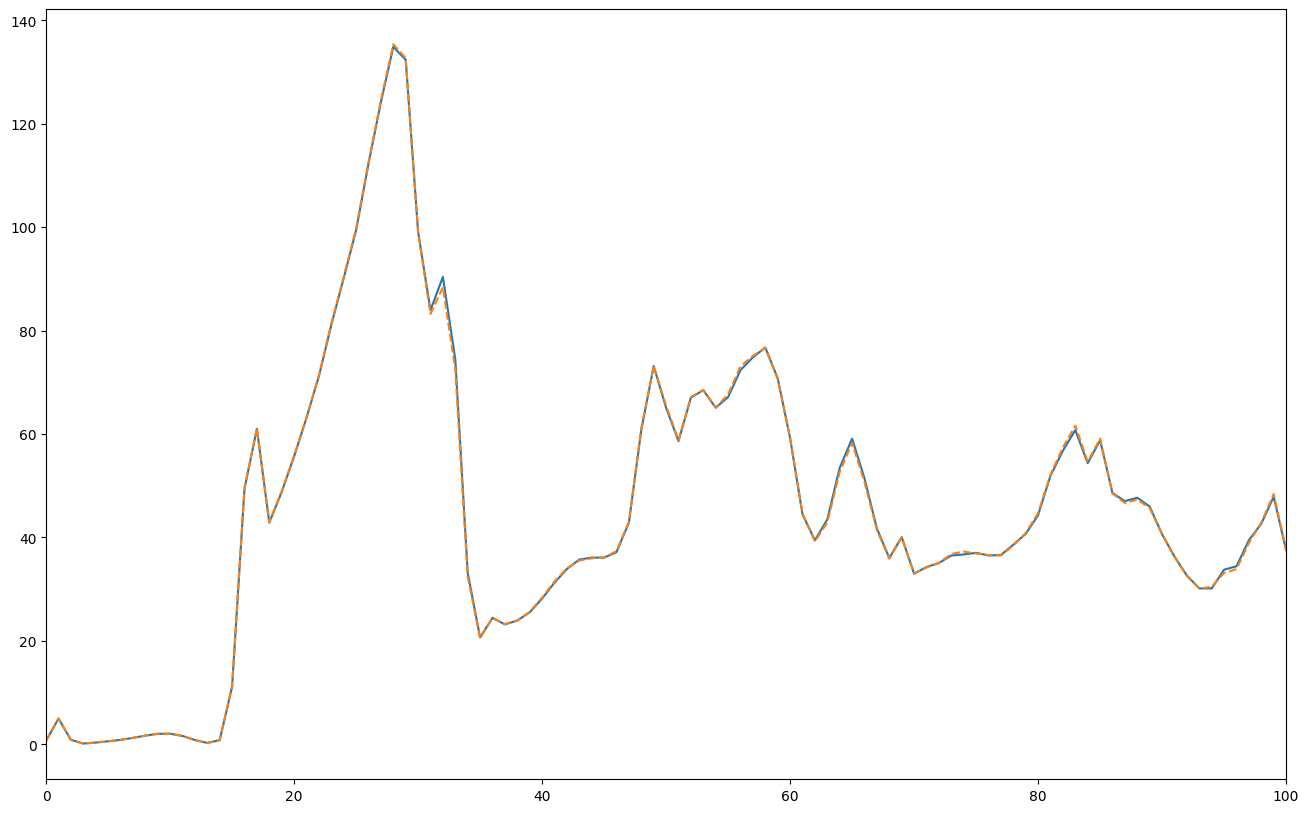

In [23]:
# Parameters for Pxxs
win_len = 1*second;
nperseg = int(win_len/second * fs_FR/Hz)
overlap_PSD = 0.99
NFFT = 2**((nperseg-1).bit_length()+1) # np.ceil(np.log2(window_width))
NFFT = nperseg

nperseg2 = int(win_len/second * fs_FR_cust)
NFFT2 = nperseg2

# Calculate the Pxxs
(f_E, Pxx_E) = welch(FR_E, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
(f_E2, Pxx_E2) = welch(FR_E_cust/N_E, fs_FR_cust, nperseg=nperseg2, nfft=NFFT2, noverlap=round(nperseg2*overlap_PSD), scaling='spectrum')

# Show the figure
plt.figure(figsize=(16,10))
plt.plot(f_E, Pxx_E)
plt.plot(f_E2, Pxx_E2, '--')
plt.xlim([0,100])
plt.show()